<a href="https://colab.research.google.com/github/umamkhan124/wildfire_Forestfire/blob/main/Fire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle


In [ ]:

from google.colab import drive
drive.mount('/content/drive')

import os
from pathlib import Path

DRIVE_BASE = Path("/content/drive/MyDrive/wildfire_project")
RAW_DIR   = DRIVE_BASE / "raw_datasets"
FINAL_DS  = DRIVE_BASE / "final_wildfire_dataset"    # persistent final dataset on Drive
WEIGHTS   = DRIVE_BASE / "weights"
MODELS    = DRIVE_BASE / "models"
os.makedirs(RAW_DIR, exist_ok=True)
os.makedirs(FINAL_DS, exist_ok=True)
os.makedirs(WEIGHTS, exist_ok=True)
os.makedirs(MODELS, exist_ok=True)

print("Drive base:", DRIVE_BASE)
print("Raw datasets folder:", RAW_DIR)
print("Final dataset folder:", FINAL_DS)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive base: /content/drive/MyDrive/wildfire_project
Raw datasets folder: /content/drive/MyDrive/wildfire_project/raw_datasets
Final dataset folder: /content/drive/MyDrive/wildfire_project/final_wildfire_dataset


In [ ]:

# note: if restarted, re-run this cell
!pip install -q ultralytics kagglehub
!pip install -q streamlit

# Install node + npx localtunnel (sometimes preinstalled, but safe to run)
!apt-get update -qq
!apt-get install -y -qq nodejs npm
# install localtunnel globally (or we will use npx)
!npm install -g localtunnel

# show versions
import sys, pkg_resources, subprocess
print("Python:", sys.version)
print("Ultralytics:", pkg_resources.get_distribution("ultralytics").version)


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)

changed 22 packages, and audited 23 packages in 1s

3 packages are looking for funding
  run `npm fund` for details

1 high severity vulnerability

To address all issues (including breaking changes), run:
  npm audit fix --force

Run `npm audit` for details.
Python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
Ultralytics: 8.3.199


/tmp/ipython-input-3417582534.py:12: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import sys, pkg_resources, subprocess


In [ ]:
# CELL B — download datasets into Drive/raw_datasets
import kagglehub, shutil
from pathlib import Path

# Kaggle IDs
FIRE_DS       = "ankan1998/fire-detection-in-yolo-format"
WILDSMOKE_DS = "ahemateja19bec1025/wildfiresmokedatasetyolo"
FIRESMOKE_DS  = "roscoekerby/firesmoke-detection-yolo-v9"
WILDFIRE_CSV  = "ananthu017/california-wildfire-incidents-20132020"

local_fire = RAW_DIR / "fire_detection_yolo"
local_wild = RAW_DIR / "wildfire_smoke_yolo"
local_fs   = RAW_DIR / "firesmoke_yolo"
local_csv  = RAW_DIR / "wildfire_csv"

def download_if_missing(ds_id, target):
    if target.exists():
        print("Skipping (exists):", target)
        return target
    print("Downloading:", ds_id)
    cached = kagglehub.dataset_download(ds_id)   # returns cache path
    print("Cached at:", cached)
    shutil.copytree(cached, target, dirs_exist_ok=True)
    print("Copied to:", target)
    return target


download_if_missing(FIRE_DS, local_fire)
download_if_missing(WILDSMOKE_DS, local_wild)
download_if_missing(FIRESMOKE_DS, local_fs)
download_if_missing(WILDFIRE_CSV, local_csv)

print("All downloads attempted. Check /content/drive/MyDrive/wildfire_project/raw_datasets/")


Skipping (exists): /content/drive/MyDrive/wildfire_project/raw_datasets/fire_detection_yolo
Skipping (exists): /content/drive/MyDrive/wildfire_project/raw_datasets/wildfire_smoke_yolo
Skipping (exists): /content/drive/MyDrive/wildfire_project/raw_datasets/firesmoke_yolo
Skipping (exists): /content/drive/MyDrive/wildfire_project/raw_datasets/wildfire_csv
All downloads attempted. Check /content/drive/MyDrive/wildfire_project/raw_datasets/


In [ ]:

import os

dataset_path = "/content/final_wildfire_dataset"

for split in ["train", "valid", "test"]:
    img_dir = os.path.join(dataset_path, split, "images")
    lbl_dir = os.path.join(dataset_path, split, "labels")

    img_count = len(os.listdir(img_dir)) if os.path.exists(img_dir) else 0
    lbl_count = len(os.listdir(lbl_dir)) if os.path.exists(lbl_dir) else 0

    print(f"\n--- {split.upper()} ---")
    print(f"Images: {img_count}")
    print(f"Labels: {lbl_count}")



--- TRAIN ---
Images: 238
Labels: 219

--- VALID ---
Images: 16
Labels: 16

--- TEST ---
Images: 11
Labels: 11


In [ ]:
# CELL 4 — Merge YOLO datasets
import shutil
from pathlib import Path
import os

# Raw dataset paths
RAW_DIR = Path("/content/drive/MyDrive/wildfire_project/raw_datasets")
fire = RAW_DIR / "fire_detection_yolo"
wild = RAW_DIR / "wildfire_smoke_yolo"
fs   = RAW_DIR / "firesmoke_yolo"

# Final dataset path
FINAL_DIR = Path("/content/final_wildfire_dataset")
splits = ["train", "valid", "test"]

# Create folder structure
for split in splits:
    (FINAL_DIR / split / "images").mkdir(parents=True, exist_ok=True)
    (FINAL_DIR / split / "labels").mkdir(parents=True, exist_ok=True)

# Function to copy images and labels, remapping classes
def merge_dataset(src_root, class_mapping):
    for split in splits:
        src_images = src_root / split / "images"
        src_labels = src_root / split / "labels"
        if not src_images.exists() or not src_labels.exists():
            continue
        for img_file in src_images.glob("*.*"):
            shutil.copy(img_file, FINAL_DIR / split / "images")
        for lbl_file in src_labels.glob("*.txt"):
            # remap classes if needed
            lines = []
            with open(lbl_file, "r") as f:
                for line in f:
                    parts = line.strip().split()
                    old_class = int(parts[0])
                    new_class = class_mapping.get(old_class, old_class)
                    lines.append(" ".join([str(new_class)] + parts[1:]))
            # write to final dataset
            shutil.copy(lbl_file, FINAL_DIR / split / "labels")
            final_lbl_file = FINAL_DIR / split / "labels" / lbl_file.name
            with open(final_lbl_file, "w") as f:
                f.write("\n".join(lines))

# Define class remapping (adjust if needed)
# Example: fire=0, smoke=1, fire+smoke=2
fire_map = {0:0}
wild_map = {0:1}
fs_map   = {0:2}

merge_dataset(fire, fire_map)
merge_dataset(wild, wild_map)
merge_dataset(fs, fs_map)

print(" Merging complete! Check /content/final_wildfire_dataset")


 Merging complete! Check /content/final_wildfire_dataset


In [ ]:

data_yaml = """
train: /content/final_wildfire_dataset/train/images
val: /content/final_wildfire_dataset/valid/images
test: /content/final_wildfire_dataset/test/images

nc: 3
names: ['fire', 'smoke', 'fire_smoke']
"""

with open("/content/final_wildfire_dataset/data.yaml", "w") as f:
    f.write(data_yaml)

print("data.yaml created!")


data.yaml created!


In [ ]:

!yolo detect train \
    data=/content/final_wildfire_dataset/data.yaml \
    model=yolov8n.pt \
    epochs=50 \
    imgsz=640 \
    batch=16 \
    device=0 \
    name=wildfire_model \
    save=True


In [ ]:
from ultralytics import YOLO
from google.colab import files
from IPython.display import Image, display
from pathlib import Path
import cv2
import numpy as np

# Load trained model
model = YOLO("/content/runs/detect/wildfire_model/weights/best.pt")

# Upload an image
uploaded = files.upload()
if len(uploaded) == 0:
    print("No file uploaded!")
else:
    img_path = list(uploaded.keys())[0]
    print("Running inference on:", img_path)

    # Run prediction
    results_list = model.predict(img_path, conf=0.25)
    results = results_list[0]

    # Check if any detections
    if results.boxes is None or len(results.boxes) == 0:
        print("No detections found in this image.")
    else:
        # Create output directory
        output_dir = Path("/content/runs/detect/wildfire_model/upload_output")
        output_dir.mkdir(parents=True, exist_ok=True)
        output_path = output_dir / "predictions.png"

        # Plot and save using OpenCV
        plotted_img = results.plot()  # returns NumPy array
        cv2.imwrite(str(output_path), cv2.cvtColor(plotted_img, cv2.COLOR_RGB2BGR))

        print(f"Predictions saved to {output_path}")

        # Display
        display(Image(str(output_path)))


In [ ]:

from ultralytics import YOLO
from google.colab import files
from IPython.display import Image, display
from pathlib import Path
import cv2
import numpy as np

# Load trained model
model = YOLO("/content/runs/detect/wildfire_model/weights/best.pt")

# Define class colors (RGB)
CLASS_COLORS = {
    "fire": (255, 0, 0),       # Red
    "smoke": (128, 128, 128),  # Gray
    "fire+smoke": (255, 165, 0) # Orange
}

# Confidence threshold
CONF_THRESH = 0.25
# NMS IoU threshold
IOU_THRESH = 0.5

# Upload one or more images
uploaded = files.upload()
if len(uploaded) == 0:
    print("No files uploaded!")
else:
    output_dir = Path("/content/runs/detect/wildfire_model/upload_output")
    output_dir.mkdir(parents=True, exist_ok=True)

    for img_name in uploaded.keys():
        print(f"Running inference on: {img_name}")

        # Run prediction with confidence and IoU thresholds
        results_list = model.predict(img_name, conf=CONF_THRESH, iou=IOU_THRESH)
        results = results_list[0]

        # Check for detections
        if results.boxes is None or len(results.boxes) == 0:
            print(f"No detections found in {img_name}.")
            continue

        # Get plotted image
        plotted_img = results.plot()

        # Overlay custom colors and show confidence on each box
        for box, cls_idx, conf in zip(results.boxes.xyxy, results.boxes.cls, results.boxes.conf):
            cls_name = results.names[int(cls_idx)]
            color = CLASS_COLORS.get(cls_name, (0, 255, 0))  # default green
            x1, y1, x2, y2 = map(int, box)
            cv2.rectangle(plotted_img, (x1, y1), (x2, y2), color, 2)
            label = f"{cls_name} {conf:.2f}"
            cv2.putText(plotted_img, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        # Save as PNG
        output_path = output_dir / f"{Path(img_name).stem}_predictions.png"
        cv2.imwrite(str(output_path), cv2.cvtColor(plotted_img, cv2.COLOR_RGB2BGR))

        print(f"Predictions saved to {output_path}")
        display(Image(str(output_path)))


In [ ]:
import random
from pathlib import Path
import shutil

train_img_dir = Path("/content/final_wildfire_dataset/train/images")
train_lbl_dir = Path("/content/final_wildfire_dataset/train/labels")

val_img_dir = Path("/content/final_wildfire_dataset/val/images")
val_lbl_dir = Path("/content/final_wildfire_dataset/val/labels")
val_img_dir.mkdir(parents=True, exist_ok=True)
val_lbl_dir.mkdir(parents=True, exist_ok=True)

all_images = list(train_img_dir.glob("*.*"))
random.shuffle(all_images)
val_count = int(0.1 * len(all_images))  # 10% for validation

for img_file in all_images[:val_count]:
    lbl_file = train_lbl_dir / f"{img_file.stem}.txt"
    shutil.move(str(img_file), val_img_dir / img_file.name)
    if lbl_file.exists():
        shutil.move(str(lbl_file), val_lbl_dir / lbl_file.name)

print("Train/Val split done!")


Train/Val split done!


In [ ]:
!ls /content/runs/detect/


wildfire_model	wildfire_model2  wildfire_model_s  wildfire_model_s2


In [ ]:
!ls /content/runs/detect/wildfire_model_s


args.yaml  weights


In [ ]:
!yolo detect train \
    data=/content/final_wildfire_dataset/data.yaml \
    model=yolov8s.pt \
    epochs=100 \
    imgsz=640 \
    batch=16 \
    device=0 \
    name=wildfire_model_s \
    save=True


Ultralytics 8.3.199 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/final_wildfire_dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=wildfire_model_s3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=

Loaded model from /content/runs/detect/wildfire_model_s2/weights/best.pt
Running inference on: pred_wildfires-cover_20161118150911007_6627016_ver1-0_640_360_jpg.rf.0beaf855b9c5a9e5e1bfac5e11e7f37c.jpg

image 1/1 /content/final_wildfire_dataset/train/images/pred_wildfires-cover_20161118150911007_6627016_ver1-0_640_360_jpg.rf.0beaf855b9c5a9e5e1bfac5e11e7f37c.jpg: 640x640 1 fire, 16.3ms
Speed: 3.6ms preprocess, 16.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


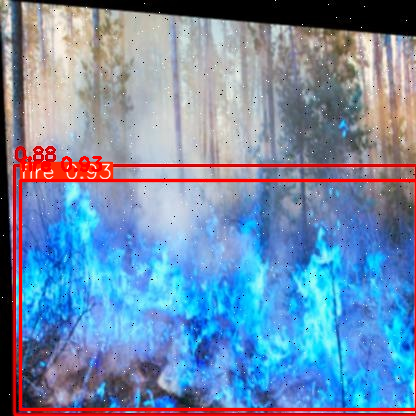

Running inference on: house-fire1_jpg.rf.4859bd4ba392a7be1f9cb1a45120dd12.jpg

image 1/1 /content/final_wildfire_dataset/train/images/house-fire1_jpg.rf.4859bd4ba392a7be1f9cb1a45120dd12.jpg: 640x640 1 fire, 16.3ms
Speed: 3.8ms preprocess, 16.3ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)


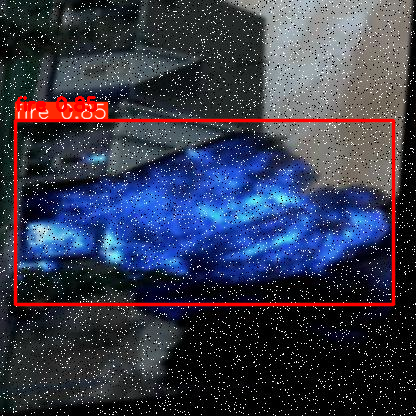

Running inference on: 90713_Wichman_FIre_004A_jpg.rf.703090023b2db47e04b353c0107e9da3.jpg

image 1/1 /content/final_wildfire_dataset/train/images/90713_Wichman_FIre_004A_jpg.rf.703090023b2db47e04b353c0107e9da3.jpg: 640x640 1 fire, 17.1ms
Speed: 4.0ms preprocess, 17.1ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


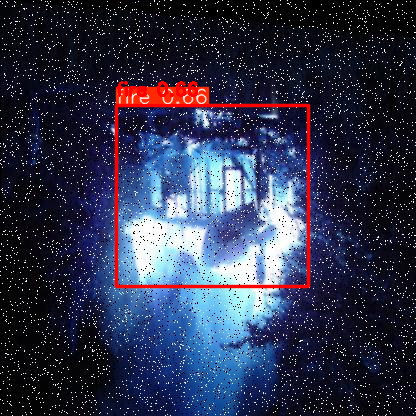

Running inference on: dsc_01001_jpg.rf.af70e6a5541a70dc846ef8cc63754740.jpg

image 1/1 /content/final_wildfire_dataset/train/images/dsc_01001_jpg.rf.af70e6a5541a70dc846ef8cc63754740.jpg: 640x640 1 fire, 17.6ms
Speed: 3.7ms preprocess, 17.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


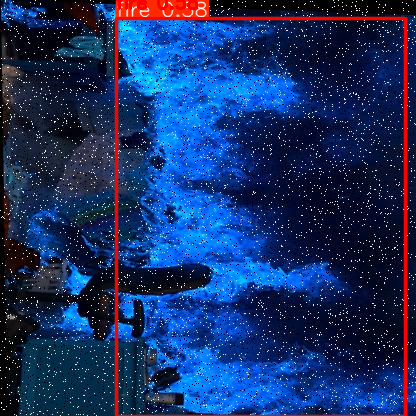

Running inference on: maxresdefault568_jpg.rf.3a5b2cc3d42d14606b13da63c018f4a5.jpg

image 1/1 /content/final_wildfire_dataset/train/images/maxresdefault568_jpg.rf.3a5b2cc3d42d14606b13da63c018f4a5.jpg: 640x640 1 fire, 16.3ms
Speed: 3.6ms preprocess, 16.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


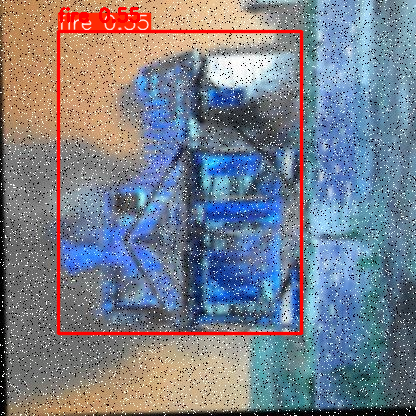

In [ ]:
from ultralytics import YOLO
from pathlib import Path
from IPython.display import Image, display
import cv2
import random
import numpy as np

# Automatically locate best.pt
weights_path = list(Path("/content/runs/detect/wildfire_model_s2").rglob("best.pt"))[0]
model = YOLO(str(weights_path))
print(f"Loaded model from {weights_path}")

# Define class colors (RGB)
CLASS_COLORS = {
    "fire": (255, 0, 0),       # Red
    "smoke": (128, 128, 128),  # Gray
    "fire+smoke": (255, 165, 0) # Orange
}

CONF_THRESH = 0.25
IOU_THRESH = 0.5

# Select images from the train dataset (or any folder)
image_dir = Path("/content/final_wildfire_dataset/train/images")
all_images = list(image_dir.glob("*.*"))
test_images = random.sample(all_images, 5)  # pick 5 images randomly

# Output folder
output_dir = Path("/content/runs/detect/wildfire_model_s2/test_output")
output_dir.mkdir(parents=True, exist_ok=True)

for img_path in test_images:
    print(f"Running inference on: {img_path.name}")

    results_list = model.predict(str(img_path), conf=CONF_THRESH, iou=IOU_THRESH)
    results = results_list[0]

    if results.boxes is None or len(results.boxes) == 0:
        print(f"No detections found in {img_path.name}.")
        continue

    # Plot detections
    plotted_img = results.plot()

    # Overlay custom colors and confidence
    for box, cls_idx, conf in zip(results.boxes.xyxy, results.boxes.cls, results.boxes.conf):
        cls_name = results.names[int(cls_idx)]
        color = CLASS_COLORS.get(cls_name, (0, 255, 0))
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(plotted_img, (x1, y1), (x2, y2), color, 2)
        cv2.putText(plotted_img, f"{cls_name} {conf:.2f}", (x1, y1-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    # Save and display
    output_path = output_dir / f"{img_path.stem}_predictions.png"
    cv2.imwrite(str(output_path), cv2.cvtColor(plotted_img, cv2.COLOR_RGB2BGR))
    display(Image(str(output_path)))


Running inference on: house_fire_jpg.rf.5ded114465a08a21a3f60f7e79419c90.jpg

image 1/1 /content/final_wildfire_dataset/train/images/house_fire_jpg.rf.5ded114465a08a21a3f60f7e79419c90.jpg: 640x640 1 fire, 16.2ms
Speed: 2.1ms preprocess, 16.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


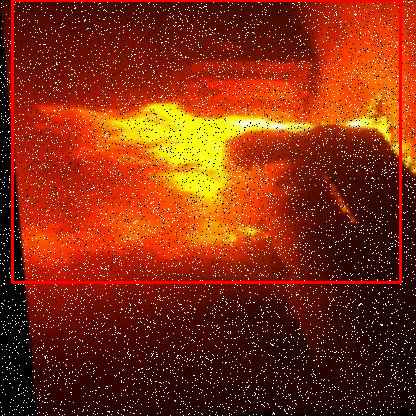

Running inference on: 32313rwev_jpg.rf.6b0383b76856e7fc0f60392b3b8e7414.jpg

image 1/1 /content/final_wildfire_dataset/train/images/32313rwev_jpg.rf.6b0383b76856e7fc0f60392b3b8e7414.jpg: 640x640 1 fire, 16.3ms
Speed: 3.7ms preprocess, 16.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


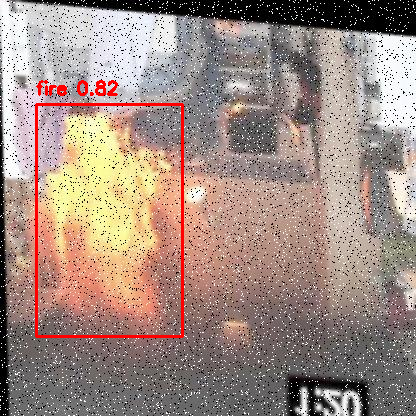

Running inference on: mfs_fire_investigation_image_bedroom_with_candles_2_jpg.rf.3b66798479655991315056de08ea3424.jpg

image 1/1 /content/final_wildfire_dataset/train/images/mfs_fire_investigation_image_bedroom_with_candles_2_jpg.rf.3b66798479655991315056de08ea3424.jpg: 640x640 2 fires, 16.3ms
Speed: 3.9ms preprocess, 16.3ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)


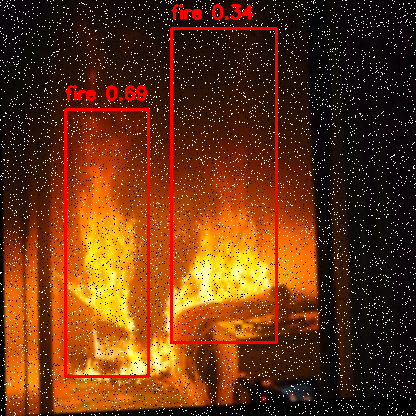

Running inference on: Christmas-Tree-Fire-Safety_jpg.rf.666fb51a198b96d7159eeaf8786f284d.jpg

image 1/1 /content/final_wildfire_dataset/train/images/Christmas-Tree-Fire-Safety_jpg.rf.666fb51a198b96d7159eeaf8786f284d.jpg: 640x640 1 fire, 16.3ms
Speed: 3.5ms preprocess, 16.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


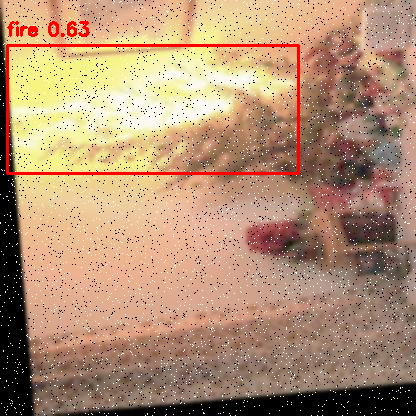

Running inference on: 13518572_jpg.rf.081527fa86c4395557231b1e627147b2.jpg

image 1/1 /content/final_wildfire_dataset/train/images/13518572_jpg.rf.081527fa86c4395557231b1e627147b2.jpg: 640x640 1 fire, 16.3ms
Speed: 3.6ms preprocess, 16.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


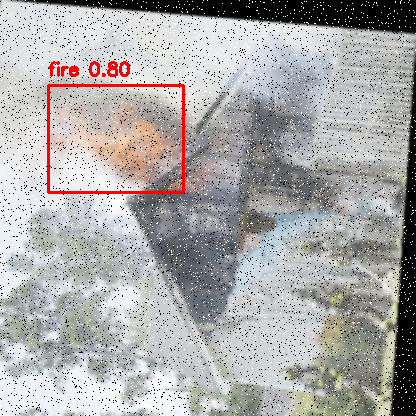

In [ ]:
from ultralytics import YOLO
from pathlib import Path
from IPython.display import Image, display
import cv2
import random

# Load model
model = YOLO("/content/runs/detect/wildfire_model_s2/weights/best.pt")

# Confidence threshold
CONF_THRESH = 0.25

# Get 5 random images from dataset
image_dir = Path("/content/final_wildfire_dataset/train/images")
all_images = list(image_dir.glob("*.*"))
test_images = random.sample(all_images, 5)

# Output folder
output_dir = Path("/content/runs/detect/wildfire_model_s2/test_output_clean")
output_dir.mkdir(parents=True, exist_ok=True)

for img_path in test_images:
    print(f"Running inference on: {img_path.name}")

    # Read original image (unchanged)
    img = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Run prediction
    results_list = model.predict(str(img_path), conf=CONF_THRESH)
    results = results_list[0]

    if results.boxes is None or len(results.boxes) == 0:
        print(f"No detections found in {img_path.name}.")
        continue

    # Draw boxes directly on original image
    for box, cls_idx, conf in zip(results.boxes.xyxy, results.boxes.cls, results.boxes.conf):
        cls_name = results.names[int(cls_idx)]
        color = (255, 0, 0)  # RED for all fire detections
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(img_rgb, (x1, y1), (x2, y2), color, 2)
        cv2.putText(img_rgb, f"{cls_name} {conf:.2f}", (x1, y1-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    # Save and display
    output_path = output_dir / f"{img_path.stem}_bbox.png"
    cv2.imwrite(str(output_path), cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR))
    display(Image(str(output_path)))


In [ ]:
from ultralytics import YOLO
from pathlib import Path
from IPython.display import Image, display
import cv2
import random
import numpy as np

# Load model
model = YOLO("/content/runs/detect/wildfire_model_s2/weights/best.pt")

CONF_THRESH = 0.25  # confidence threshold

# Select 5 random images
image_dir = Path("/content/final_wildfire_dataset/train/images")
all_images = list(image_dir.glob("*.*"))
test_images = random.sample(all_images, 5)

# Output folder
output_dir = Path("/content/runs/detect/wildfire_model_s2/test_output_clean")
output_dir.mkdir(parents=True, exist_ok=True)

for img_path in test_images:
    print(f"Running inference on: {img_path.name}")

    # Read original image
    img = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Run prediction
    results_list = model.predict(str(img_path), conf=CONF_THRESH)
    results = results_list[0]

    if results.boxes is None or len(results.boxes) == 0:
        print(f"No detections found in {img_path.name}.")
        continue

    # Convert boxes, confs, classes to arrays
    boxes = results.boxes.xyxy.cpu().numpy()
    confs = results.boxes.conf.cpu().numpy()
    classes = results.boxes.cls.cpu().numpy().astype(int)

    # Filter out very small boxes (width or height < 5 pixels)
    filtered_indices = []
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = box
        if (x2 - x1) >= 5 and (y2 - y1) >= 5:
            filtered_indices.append(i)

    boxes = boxes[filtered_indices]
    confs = confs[filtered_indices]
    classes = classes[filtered_indices]

    # Keep only highest-confidence box per class
    unique_classes = np.unique(classes)
    final_boxes = []
    final_confs = []
    final_classes = []
    for cls in unique_classes:
        cls_indices = np.where(classes == cls)[0]
        best_idx = cls_indices[np.argmax(confs[cls_indices])]
        final_boxes.append(boxes[best_idx])
        final_confs.append(confs[best_idx])
        final_classes.append(cls)

    # Draw boxes and confidence
    for box, conf, cls_idx in zip(final_boxes, final_confs, final_classes):
        x1, y1, x2, y2 = map(int, box)
        color = (255, 0, 0)  # Red for fire
        cls_name = results.names[cls_idx]
        cv2.rectangle(img_rgb, (x1, y1), (x2, y2), color, 2)
        cv2.putText(img_rgb, f"{cls_name} {conf:.2f}", (x1, y1-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    # Save and display
    output_path = output_dir / f"{img_path.stem}_bbox_clean.png"
    cv2.imwrite(str(output_path), cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR))
    display(Image(str(output_path)))


In [ ]:
from ultralytics import YOLO
from pathlib import Path
from IPython.display import Image, display
import cv2
import random
import numpy as np

# Load model
model = YOLO("/content/runs/detect/wildfire_model_s2/weights/best.pt")

CONF_THRESH = 0.25  # confidence threshold

# Select 5 random images
image_dir = Path("/content/final_wildfire_dataset/train/images")
all_images = list(image_dir.glob("*.*"))
test_images = random.sample(all_images, 5)

# Output folder
output_dir = Path("/content/runs/detect/wildfire_model_s2/test_output_blue")
output_dir.mkdir(parents=True, exist_ok=True)

for img_path in test_images:
    print(f"Running inference on: {img_path.name}")

    # Read original image
    img = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Run prediction
    results_list = model.predict(str(img_path), conf=CONF_THRESH)
    results = results_list[0]

    if results.boxes is None or len(results.boxes) == 0:
        print(f"No detections found in {img_path.name}.")
        continue

    # Convert boxes, confs, classes to arrays
    boxes = results.boxes.xyxy.cpu().numpy()
    confs = results.boxes.conf.cpu().numpy()
    classes = results.boxes.cls.cpu().numpy().astype(int)

    # Filter out very small boxes (width or height < 5 pixels)
    filtered_indices = []
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = box
        if (x2 - x1) >= 5 and (y2 - y1) >= 5:
            filtered_indices.append(i)

    boxes = boxes[filtered_indices]
    confs = confs[filtered_indices]
    classes = classes[filtered_indices]

    # Keep only highest-confidence box per class
    unique_classes = np.unique(classes)
    final_boxes = []
    final_confs = []
    final_classes = []
    for cls in unique_classes:
        cls_indices = np.where(classes == cls)[0]
        best_idx = cls_indices[np.argmax(confs[cls_indices])]
        final_boxes.append(boxes[best_idx])
        final_confs.append(confs[best_idx])
        final_classes.append(cls)

    # Draw boxes and confidence in BLUE
    for box, conf, cls_idx in zip(final_boxes, final_confs, final_classes):
        x1, y1, x2, y2 = map(int, box)
        color = (0, 0, 255)  # Blue in OpenCV (BGR)
        cls_name = results.names[cls_idx]
        cv2.rectangle


Running inference on: 25A072C400000578-2951223-image-a-15_1423799067621_jpg.rf.3b5a686298a8bfb3c82a815f90373ff4.jpg

image 1/1 /content/final_wildfire_dataset/train/images/25A072C400000578-2951223-image-a-15_1423799067621_jpg.rf.3b5a686298a8bfb3c82a815f90373ff4.jpg: 640x640 1 fire, 16.2ms
Speed: 3.6ms preprocess, 16.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)
Running inference on: 27F1075800000578-0-image-a-1_1429880815919_jpg.rf.8242c2c0bdff2ef89c3c6e2cdeadd24e.jpg

image 1/1 /content/final_wildfire_dataset/train/images/27F1075800000578-0-image-a-1_1429880815919_jpg.rf.8242c2c0bdff2ef89c3c6e2cdeadd24e.jpg: 640x640 1 fire, 16.2ms
Speed: 5.2ms preprocess, 16.2ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)
Running inference on: house_fire_jpg.rf.e6b46a3459acb307a612307511a51d65.jpg

image 1/1 /content/final_wildfire_dataset/train/images/house_fire_jpg.rf.e6b46a3459acb307a612307511a51d65.jpg: 640x640 2 fires, 16.3ms
Speed: 3.3ms preprocess, 16

In [ ]:

unique_classes = np.unique(classes)
final_boxes = []
final_confs = []
final_classes = []
for cls in unique_classes:
    cls_indices = np.where(classes == cls)[0]  # <-- corrected here
    best_idx = cls_indices[np.argmax(confs[cls_indices])]
    final_boxes.append(boxes[best_idx])
    final_confs.append(confs[best_idx])
    final_classes.append(cls)


In [ ]:
from ultralytics import YOLO
from pathlib import Path
from IPython.display import Image, display
import cv2
import random
import numpy as np

# Load model
model = YOLO("/content/runs/detect/wildfire_model_s2/weights/best.pt")

CONF_THRESH = 0.25  # confidence threshold

# Select 5 random images from dataset
image_dir = Path("/content/final_wildfire_dataset/train/images")
all_images = list(image_dir.glob("*.*"))
test_images = random.sample(all_images, 5)

# Output folder
output_dir = Path("/content/runs/detect/wildfire_model_s2/test_output_blue")
output_dir.mkdir(parents=True, exist_ok=True)

for img_path in test_images:
    print(f"Running inference on: {img_path.name}")

    # Read original image
    img = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Run prediction
    results_list = model.predict(str(img_path), conf=CONF_THRESH)
    results = results_list[0]

    if results.boxes is None or len(results.boxes) == 0:
        print(f"No detections found in {img_path.name}.")
        continue

    # Convert boxes, confs, classes to arrays
    boxes = results.boxes.xyxy.cpu().numpy()
    confs = results.boxes.conf.cpu().numpy()
    classes = results.boxes.cls.cpu().numpy().astype(int)

    # Filter out very small boxes (width or height < 5 pixels)
    filtered_indices = []
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = box
        if (x2 - x1) >= 5 and (y2 - y1) >= 5:
            filtered_indices.append(i)

    boxes = boxes[filtered_indices]
    confs = confs[filtered_indices]
    classes = classes[filtered_indices]

    # Keep only highest-confidence box per class
    unique_classes = np.unique(classes)
    final_boxes = []
    final_confs = []
    final_classes = []
    for cls in unique_classes:
        cls_indices = np.where(classes == cls)[0]  # corrected here
        best_idx = cls_indices[np.argmax(confs[cls_indices])]
        final_boxes.append(boxes[best_idx])
        final_confs.append(confs[best_idx])
        final_classes.append(cls)

    # Draw boxes and confidence in BLUE
    for box, conf, cls_idx in zip(final_boxes, final_confs, final_classes):
        x1, y1, x2, y2 = map(int, box)
        color = (0, 0, 255)  # Blue in OpenCV (BGR)
        cls_name = results.names[cls_idx]
        cv2.rectangle(img_rgb, (x1, y1), (x2, y2), color, 2)
        cv2.putText(img_rgb, f"{cls_name} {conf:.2f}", (x1, y1-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    # Save image
    output_path = output_dir / f"{img_path.stem}_bbox_blue.png"
    cv2.imwrite(str(output_path), cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR))

    # Display image in Colab
    display(Image(filename=str(output_path)))


In [ ]:
from ultralytics import YOLO
from google.colab import files
from IPython.display import Image, display
from pathlib import Path
import cv2
import numpy as np

# Load trained model
model = YOLO("/content/runs/detect/wildfire_model_s2/weights/best.pt")

CONF_THRESH = 0.25  # confidence threshold

# Upload a random image
uploaded = files.upload()
if len(uploaded) == 0:
    print("No file uploaded!")
else:
    img_path = list(uploaded.keys())[0]
    print(f"Running inference on: {img_path}")

    # Read image
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Run prediction
    results_list = model.predict(img_path, conf=CONF_THRESH)
    results = results_list[0]

    if results.boxes is None or len(results.boxes) == 0:
        print("No detections found.")
    else:
        # Convert boxes, confs, classes to arrays
        boxes = results.boxes.xyxy.cpu().numpy()
        confs = results.boxes.conf.cpu().numpy()
        classes = results.boxes.cls.cpu().numpy().astype(int)

        # Filter out tiny boxes
        filtered_indices = [i for i, box in enumerate(boxes) if (box[2]-box[0] >=5 and box[3]-box[1] >=5)]
        boxes = boxes[filtered_indices]
        confs = confs[filtered_indices]
        classes = classes[filtered_indices]

        # Keep highest-confidence box per class
        final_boxes, final_confs, final_classes = [], [], []
        for cls in np.unique(classes):
            cls_indices = np.where(classes == cls)[0]
            best_idx = cls_indices[np.argmax(confs[cls_indices])]
            final_boxes.append(boxes[best_idx])
            final_confs.append(confs[best_idx])
            final_classes.append(cls)

        # Draw boxes and confidence in BLUE
        for box, conf, cls_idx in zip(final_boxes, final_confs, final_classes):
            x1, y1, x2, y2 = map(int, box)
            color = (0, 0, 255)  # Blue in OpenCV (BGR)
            cls_name = results.names[cls_idx]
            cv2.rectangle(img_rgb, (x1, y1), (x2, y2), color, 2)
            cv2.putText(img_rgb, f"{cls_name} {conf:.2f}", (x1, y1-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        # Save and display
        output_dir = Path("/content/runs/detect/wildfire_model_s2/random_test")
        output_dir.mkdir(parents=True, exist_ok=True)
        output_path = output_dir / f"{Path(img_path).stem}_bbox_blue.png"
        cv2.imwrite(str(output_path), cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR))
        display(Image(filename=str(output_path)))


Saving what-colour-is-sun-1757659642648.webp to what-colour-is-sun-1757659642648 (1).webp
Running inference on: what-colour-is-sun-1757659642648 (1).webp

image 1/1 /content/what-colour-is-sun-1757659642648 (1).webp: 384x640 (no detections), 45.1ms
Speed: 2.1ms preprocess, 45.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
No detections found.


In [ ]:
from ultralytics import YOLO
from google.colab import files
from IPython.display import Image, display
from pathlib import Path
import cv2
import numpy as np

# Load model
model = YOLO("/content/runs/detect/wildfire_model_s2/weights/best.pt")
CONF_THRESH = 0.25  # Confidence threshold

# Upload a random image
uploaded = files.upload()
if not uploaded:
    print("No file uploaded!")
else:
    img_path = list(uploaded.keys())[0]
    print(f"Running inference on: {img_path}")

    # Read image
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Predict
    results_list = model.predict(img_path, conf=CONF_THRESH)
    results = results_list[0]

    if results.boxes is None or len(results.boxes) == 0:
        print("No detections found.")
    else:
        # Extract boxes, confidences, and classes
        boxes = results.boxes.xyxy.cpu().numpy()
        confs = results.boxes.conf.cpu().numpy()
        classes = results.boxes.cls.cpu().numpy().astype(int)


        indices = [i for i, box in enumerate(boxes) if (box[2]-box[0] >=5 and box[3]-box[1] >=5)]
        boxes = boxes[indices]
        confs = confs[indices]
        classes = classes[indices]

        # Draw each box with blue color
        for box, conf, cls_idx in zip(boxes, confs, classes):
            x1, y1, x2, y2 = map(int, box)
            color = (0, 0, 255)  # Blue in BGR
            cls_name = results.names[cls_idx]
            # Draw rectangle
            cv2.rectangle(img_rgb, (x1, y1), (x2, y2), color, 2)
            # Draw confidence text slightly above the box
            text_pos_y = max(0, y1-10)  # avoid text going off top
            cv2.putText(img_rgb, f"{cls_name} {conf:.2f}", (x1, text_pos_y),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        # Save and display
        output_dir = Path("/content/runs/detect/wildfire_model_s2/random_output_blue")
        output_dir.mkdir(parents=True, exist_ok=True)
        output_path = output_dir / f"{Path(img_path).stem}_bbox_blue.png"
        cv2.imwrite(str(output_path), cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR))
        display(Image(filename=str(output_path)))


In [ ]:
results = model.predict(img_path, conf=0.2)



image 1/1 /content/wildfire_1400 (5).webp: 448x640 1 fire, 12.8ms
Speed: 2.3ms preprocess, 12.8ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


Running inference on: maxresdefault23_jpg.rf.2f90a53bff3bb4fd923e7069cd6a3d78.jpg

image 1/1 /content/final_wildfire_dataset/train/images/maxresdefault23_jpg.rf.2f90a53bff3bb4fd923e7069cd6a3d78.jpg: 640x640 1 fire, 16.2ms
Speed: 2.4ms preprocess, 16.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


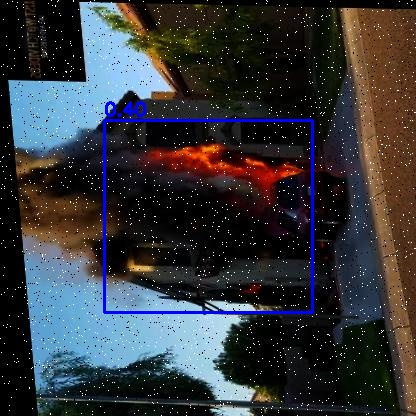

Running inference on: 32313rwev_jpg.rf.6b0383b76856e7fc0f60392b3b8e7414.jpg

image 1/1 /content/final_wildfire_dataset/train/images/32313rwev_jpg.rf.6b0383b76856e7fc0f60392b3b8e7414.jpg: 640x640 1 fire, 19.6ms
Speed: 3.8ms preprocess, 19.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


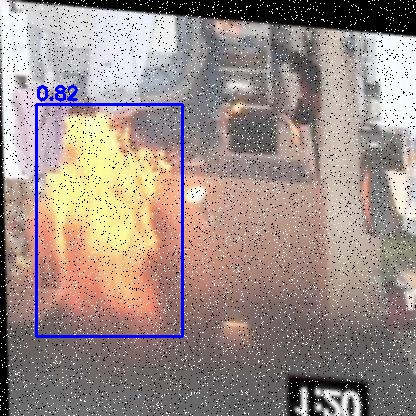

Running inference on: 90713_Wichman_FIre_004A_jpg.rf.036f7e3dc4328187aae99e85546c6937.jpg

image 1/1 /content/final_wildfire_dataset/train/images/90713_Wichman_FIre_004A_jpg.rf.036f7e3dc4328187aae99e85546c6937.jpg: 640x640 1 fire, 16.3ms
Speed: 3.5ms preprocess, 16.3ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


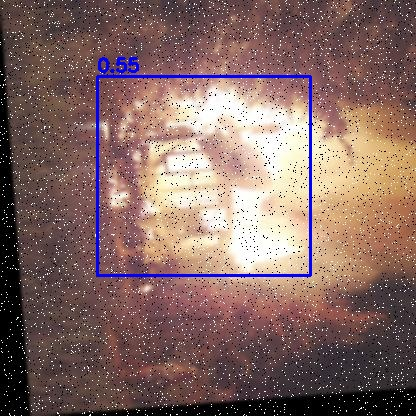

Running inference on: incendie-noel_jpg.rf.9e3aeed9eab61461c4868c3574925e91.jpg

image 1/1 /content/final_wildfire_dataset/train/images/incendie-noel_jpg.rf.9e3aeed9eab61461c4868c3574925e91.jpg: 640x640 1 fire, 16.3ms
Speed: 4.4ms preprocess, 16.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


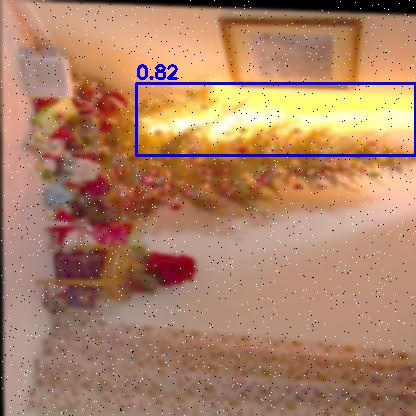

Running inference on: 90713_Wichman_FIre_004A_jpg.rf.703090023b2db47e04b353c0107e9da3.jpg

image 1/1 /content/final_wildfire_dataset/train/images/90713_Wichman_FIre_004A_jpg.rf.703090023b2db47e04b353c0107e9da3.jpg: 640x640 1 fire, 16.2ms
Speed: 3.2ms preprocess, 16.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


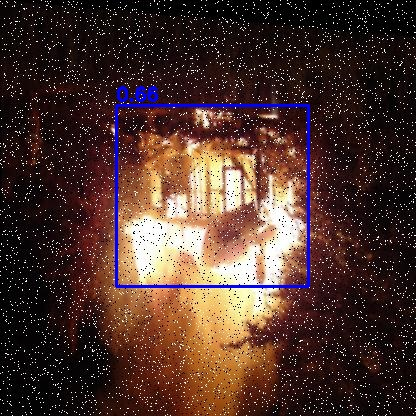

Running inference on: incendiu-acoperis_jpg.rf.1813ddd0f4556670247d543826e258c2.jpg

image 1/1 /content/final_wildfire_dataset/train/images/incendiu-acoperis_jpg.rf.1813ddd0f4556670247d543826e258c2.jpg: 640x640 2 fires, 16.3ms
Speed: 3.4ms preprocess, 16.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


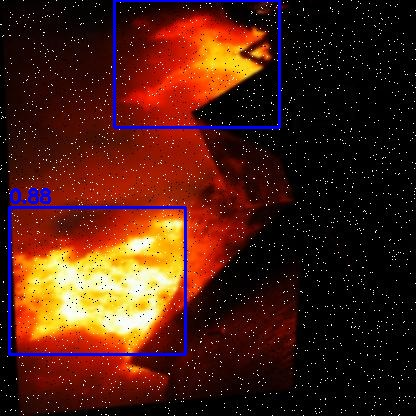

Running inference on: burning-houses-1-300x214_jpg.rf.7646bdc3b7795baebe92071db547e428.jpg

image 1/1 /content/final_wildfire_dataset/train/images/burning-houses-1-300x214_jpg.rf.7646bdc3b7795baebe92071db547e428.jpg: 640x640 1 fire, 16.3ms
Speed: 3.2ms preprocess, 16.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


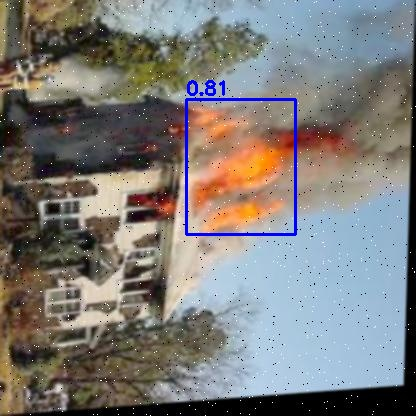

Running inference on: wildfire4_jpg.rf.07cf8edc3511401e1387446a6fa01d9b.jpg

image 1/1 /content/final_wildfire_dataset/train/images/wildfire4_jpg.rf.07cf8edc3511401e1387446a6fa01d9b.jpg: 640x640 2 fires, 16.3ms
Speed: 3.3ms preprocess, 16.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


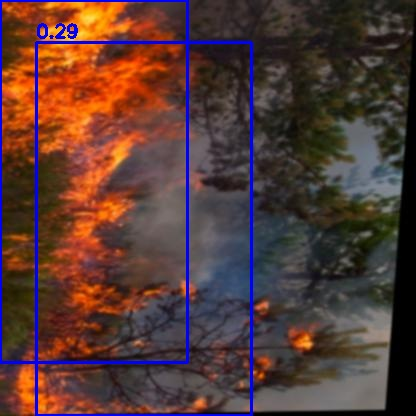

Running inference on: article-urn-publicid-ap-org-d8f7d3843cf1498b9ca96b1195c90427-3Y8qqBnFtobb1933fd918ac4b382-364_634x422_jpg.rf.c728c2f4e1b97b03b4af42ea409b5419.jpg

image 1/1 /content/final_wildfire_dataset/train/images/article-urn-publicid-ap-org-d8f7d3843cf1498b9ca96b1195c90427-3Y8qqBnFtobb1933fd918ac4b382-364_634x422_jpg.rf.c728c2f4e1b97b03b4af42ea409b5419.jpg: 640x640 2 fires, 13.4ms
Speed: 3.6ms preprocess, 13.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


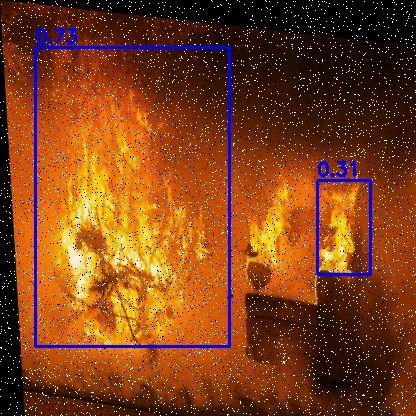

Running inference on: 14_jpg.rf.e4d259ed2d8a1dfc42cc6a5637b25891.jpg

image 1/1 /content/final_wildfire_dataset/train/images/14_jpg.rf.e4d259ed2d8a1dfc42cc6a5637b25891.jpg: 640x640 1 fire, 13.4ms
Speed: 3.3ms preprocess, 13.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


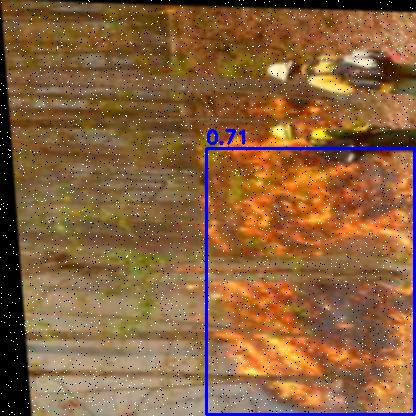

In [ ]:
from ultralytics import YOLO
from IPython.display import display, Image
from pathlib import Path
import random
import cv2
import numpy as np

# --- Load trained model ---
model_path = "/content/runs/detect/wildfire_model_s2/weights/best.pt"
model = YOLO(model_path)

# --- Dataset path ---
dataset_images = Path("/content/final_wildfire_dataset/train/images")

# Pick 10 random images
all_images = list(dataset_images.glob("*.*"))
random_images = random.sample(all_images, min(10, len(all_images)))

# --- Inference and display ---
for img_path in random_images:
    print("Running inference on:", img_path.name)

    results_list = model.predict(str(img_path), conf=0.25)
    results = results_list[0]

    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if results.boxes is None or len(results.boxes) == 0:
        print("No detections found.\n")
        display(Image(str(img_path)))
        continue

    # Draw boxes and confidence labels manually (blue)
    for box, conf in zip(results.boxes.xyxy, results.boxes.conf):
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 2)  # blue box
        text = f"{conf:.2f}"
        cv2.putText(img, text, (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

    # Save and display
    output_path = img_path.parent / f"pred_{img_path.name}"
    cv2.imwrite(str(output_path), cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    display(Image(str(output_path)))


MSE: 0.3474, R2: 0.0000


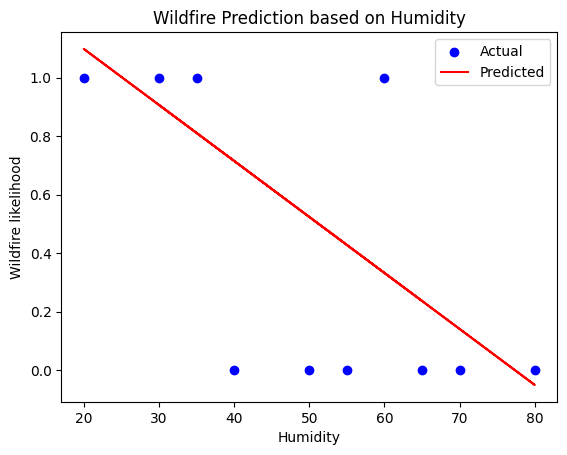

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# --- Example dataset ---
data = {
    'humidity': [30, 40, 50, 60, 70, 80, 20, 35, 55, 65],
    'wildfire': [1, 0, 0, 1, 0, 0, 1, 1, 0, 0]
}
df = pd.DataFrame(data)

# --- Features and target ---
X = df[['humidity']]
y = df['wildfire']

# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Train model ---
model = LinearRegression()
model.fit(X_train, y_train)

# --- Predictions ---
y_pred = model.predict(X_test)

# --- Evaluation ---
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse:.4f}, R2: {r2:.4f}")

# --- Plot ---
plt.scatter(X, y, color='blue', label='Actual')
plt.plot(X, model.predict(X), color='red', label='Predicted')
plt.xlabel('Humidity')
plt.ylabel('Wildfire likelihood')
plt.title('Wildfire Prediction based on Humidity')
plt.legend()
plt.show()


In [ ]:
from ultralytics import YOLO
from pathlib import Path
import cv2
from IPython.display import display, Image
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


In [ ]:
model_path = "/content/runs/detect/wildfire_model_s2/weights/best.pt"  # adjust if needed
model = YOLO(model_path)


In [ ]:
dataset_images = Path("/content/final_wildfire_dataset/train/images")  # adjust path
all_images = list(dataset_images.glob("*.*"))
random_images = random.sample(all_images, min(10, len(all_images)))

# Simulated humidity values
humidity_values = {img.name: random.randint(20, 90) for img in random_images}


In [ ]:
detection_data = []

for img_path in random_images:
    print("Running inference on:", img_path.name)

    results_list = model.predict(str(img_path), conf=0.25)
    results = results_list[0]

    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if results.boxes is None or len(results.boxes) == 0:
        wildfire_detected = 0
    else:
        wildfire_detected = 1
        for box, conf in zip(results.boxes.xyxy, results.boxes.conf):
            x1, y1, x2, y2 = map(int, box)
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 2)
            cv2.putText(img, f"{conf:.2f}", (x1, y1-5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

    output_path = img_path.parent / f"pred_{img_path.name}"
    cv2.imwrite(str(output_path), cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    display(Image(str(output_path)))

    detection_data.append({
        "image": img_path.name,
        "humidity": humidity_values[img_path.name],
        "wildfire": wildfire_detected
    })


In [ ]:
df = pd.DataFrame(detection_data)
print("\nDetection + humidity data:")
print(df)



Detection + humidity data:
                                               image  humidity  wildfire
0  image_update_img_jpg.rf.9ea96d96910d23bd1aed6c...        68         1
1  Still1115_00000_1479245056445_7039374_ver1-0_j...        40         1
2  Christmas-Tree-Fire-Safety_jpg.rf.b31a29919b87...        81         1
3  pred_aggiecrk-wildfire-07072015-usfs-580_jpg.r...        82         1
4  pred_wildfire4_jpg.rf.07cf8edc3511401e1387446a...        31         1
5  Still1115_00000_1479245056445_7039374_ver1-0_j...        66         1
6  FIR_LKC_ART_01_Detectingfire_bedroomfire_jpg.r...        59         1
7  dsc_01001_jpg.rf.af70e6a5541a70dc846ef8cc63754...        23         1
8  fire-22323_jpg.rf.2a9a57e7788e0a81e6a5fcf37fb9...        79         1
9  maxresdefault23_jpg.rf.15080b4ca39f15ed8fc2fdf...        82         1


In [ ]:
X = df[['humidity']]
y = df['wildfire']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

y_pred = reg_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"\nRegression MSE: {mse:.4f}, R²: {r2:.4f}")



Regression MSE: 0.0000, R²: 1.0000


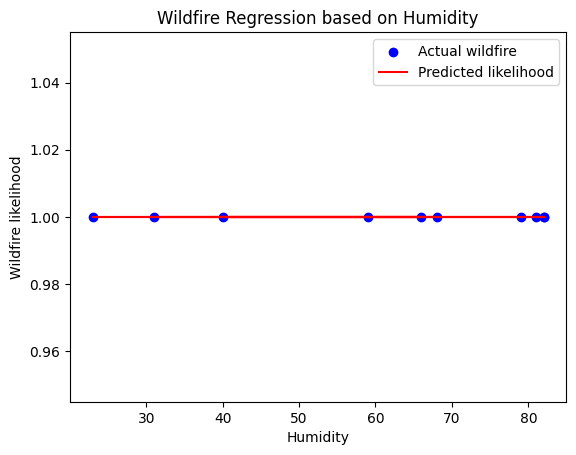

In [ ]:
plt.scatter(X, y, color='blue', label='Actual wildfire')
plt.plot(X, reg_model.predict(X), color='red', label='Predicted likelihood')
plt.xlabel('Humidity')
plt.ylabel('Wildfire likelihood')
plt.title('Wildfire Regression based on Humidity')
plt.legend()
plt.show()


In [ ]:
if results.boxes is None or len(results.boxes) == 0:
    wildfire_detected = 0
    max_conf = 0
else:
    wildfire_detected = 1
    max_conf = max(results.boxes.conf).item()  # maximum confidence among all boxes


In [ ]:
detection_data.append({
    "image": img_path.name,
    "humidity": humidity_values[img_path.name],
    "wildfire": wildfire_detected,
    "wildfire_confidence": max_conf
})


In [ ]:
detection_data = []

for img_path in random_images:
    results_list = model.predict(str(img_path), conf=0.25)
    results = results_list[0]

    if results.boxes is None or len(results.boxes) == 0:
        wildfire_detected = 0
        max_conf = 0
    else:
        wildfire_detected = 1
        max_conf = max(results.boxes.conf).item()  # get max confidence

    detection_data.append({
        "image": img_path.name,
        "humidity": humidity_values[img_path.name],
        "wildfire": wildfire_detected,
        "wildfire_confidence": max_conf
    })

df = pd.DataFrame(detection_data)



image 1/1 /content/final_wildfire_dataset/train/images/image_update_img_jpg.rf.9ea96d96910d23bd1aed6c0144261616.jpg: 640x640 4 fires, 16.3ms
Speed: 3.3ms preprocess, 16.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/final_wildfire_dataset/train/images/Still1115_00000_1479245056445_7039374_ver1-0_jpg.rf.b0abb699304da42d024c7cbccabcd9bd.jpg: 640x640 6 fires, 16.2ms
Speed: 2.1ms preprocess, 16.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/final_wildfire_dataset/train/images/Christmas-Tree-Fire-Safety_jpg.rf.b31a29919b8704f7f338864a6076ad1c.jpg: 640x640 1 fire, 16.2ms
Speed: 2.1ms preprocess, 16.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/final_wildfire_dataset/train/images/pred_aggiecrk-wildfire-07072015-usfs-580_jpg.rf.15246a60bcf26302b15dd822362d68f8.jpg: 640x640 1 fire, 16.2ms
Speed: 2.2ms preprocess, 16.2ms inference, 1.4ms postprocess per image at shape (

In [ ]:
df_filtered = df[df['wildfire_confidence'] >= 0.3]


Saving ChatGPT Image Sep 14, 2025, 11_20_20 AM.png to ChatGPT Image Sep 14, 2025, 11_20_20 AM (1).png
Running inference on: ChatGPT Image Sep 14, 2025, 11_20_20 AM (1).png

image 1/1 /content/ChatGPT Image Sep 14, 2025, 11_20_20 AM (1).png: 640x640 1 fire, 16.3ms
Speed: 2.8ms preprocess, 16.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


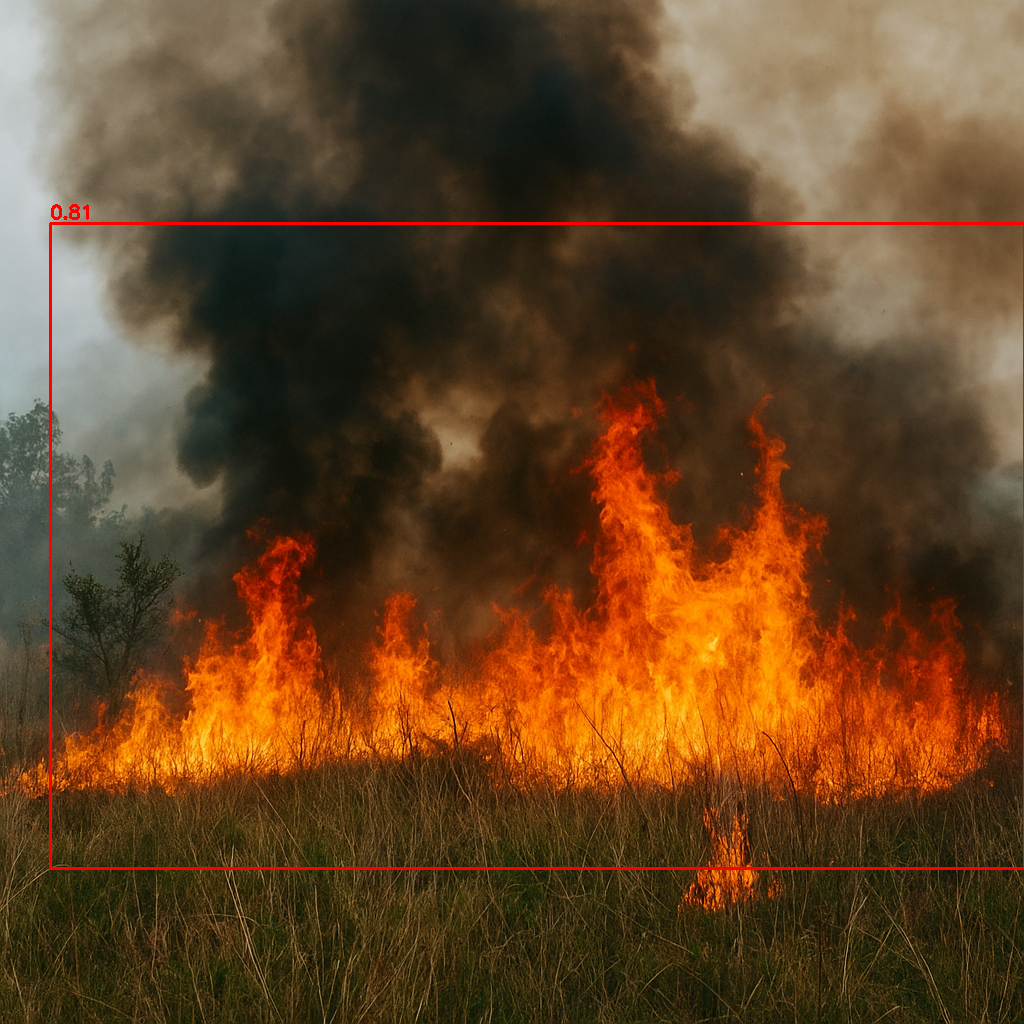

In [ ]:
from ultralytics import YOLO
from google.colab import files
from IPython.display import Image, display
from pathlib import Path
import cv2
import numpy as np

# Load trained model
model = YOLO("/content/runs/detect/wildfire_model_s2/weights/best.pt")  # adjust path if needed

# Upload your candle flame image
uploaded = files.upload()
if len(uploaded) == 0:
    print("No file uploaded!")
else:
    img_path = list(uploaded.keys())[0]
    print("Running inference on:", img_path)

    # Run YOLO prediction
    results_list = model.predict(img_path, conf=0.2)  # lower conf to catch subtle flames
    results = results_list[0]

    # Read original image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Draw boxes and confidence
    if results.boxes is None or len(results.boxes) == 0:
        print("No fire detected in this image.")
    else:
        for box, conf in zip(results.boxes.xyxy, results.boxes.conf):
            x1, y1, x2, y2 = map(int, box)
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Blue box
            cv2.putText(img, f"{conf:.2f}", (x1, y1-5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)  # Blue text

        # Save and display
        output_path = Path(img_path).parent / f"pred_{img_path}"
        cv2.imwrite(str(output_path), cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
        display(Image(str(output_path)))


In [ ]:
!pip install streamlit-folium folium


In [ ]:
# Install Streamlit and LocalTunnel
!pip install -q streamlit
!npm install -g localtunnel


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 73.6 MB/s eta 0:00:00
⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼
added 22 packages in 3s
⠼
⠼3 packages are looking for funding
⠼  run `npm fund` for details
⠼

In [ ]:
%%writefile app.py
import streamlit as st
from PIL import Image
from ultralytics import YOLO

st.set_page_config(page_title="Wildfire Detection", layout="wide")
st.title("🔥 Wildfire Detection & Hotspots 🔥")

# Upload image
uploaded_file = st.file_uploader("Upload an image of fire or environment:", type=["jpg","png","jpeg"])
if uploaded_file:
    image = Image.open(uploaded_file)
    st.image(image, caption="Uploaded Image", use_column_width=True)

    # Load YOLO model
    model = YOLO("/content/runs/detect/wildfire_model/weights/best.pt")
    results = model.predict(uploaded_file, conf=0.25)[0]

    # Show predictions
    if results.boxes is not None and len(results.boxes) > 0:
        st.success("⚠️ Fire Detected!")
        annotated_img = results.plot()
        st.image(annotated_img, caption="Detection Result", use_column_width=True)
        for i, conf in enumerate(results.boxes.conf.tolist()):
            st.write(f"Box {i+1} confidence: {conf:.2f}")
        # Optional: add safety, regression, spread info
        st.markdown("### Safety Measures & Mitigation")
        st.markdown("- Evacuate immediately if fire is nearby 🔥")
        st.markdown("- Call emergency helplines ☎️")
        st.markdown("- Monitor fire spread and wind direction 🌬️")
    else:
        st.success("✅ No fire detected! You're safe! 😎🌳")


Overwriting app.py


In [ ]:
%%writefile app.py
import streamlit as st
import torch
from pathlib import Path
from PIL import Image
import requests
import folium
from streamlit_folium import st_folium

# Title
st.title("🔥 Wildfire Detection & Monitoring App")

# File uploader
uploaded_file = st.file_uploader("Upload an image for wildfire detection", type=["jpg", "png", "jpeg"])

# Load YOLO model (replace with your trained weights path)
model = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/best.pt')

if uploaded_file is not None:
    img = Image.open(uploaded_file)
    st.image(img, caption="Uploaded Image", use_column_width=True)

    # Run detection
    results = model(img)
    df = results.pandas().xyxy[0]

    if df.empty:
        st.success("✅ No wildfire detected! Stay safe 🙂")
    else:
        st.warning("🔥 Wildfire detected!")
        st.write(df[["name", "confidence"]])

        # Show image with boxes
        st.image(results.render()[0], caption="Detection Result", use_column_width=True)

# Hotspots section
st.header("🌍 Global Wildfire Hotspots")
m = folium.Map(location=[20,0], zoom_start=2)
folium.Marker([37.7749, -122.4194], popup="California, USA 🔥").add_to(m)
folium.Marker([30.3753, 69.3451], popup="Pakistan 🔥").add_to(m)
st_folium(m, width=700, height=500)

# News Section
st.header("📰 Latest Wildfire News")
st.markdown("👉 [Click here for wildfire updates](https://www.google.com/search?q=wildfire+news)")


Overwriting app.py


In [ ]:
!ngrok config add-authtoken 32gWva0A1wQ8SVKIhWBs4MHLEr5_7AELvCtG9ZfXEZDr1JKqu


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
!pip install pyngrok streamlit -q


In [ ]:
!pkill streamlit


In [ ]:
!streamlit run app.py --server.port 8501 &>/content/logs.txt &


In [ ]:
%%writefile app.py
import streamlit as st
import folium
from streamlit_folium import st_folium
import requests
from PIL import Image
import io

# -------------------------------
# Title and intro
# -------------------------------
st.set_page_config(page_title="🔥 Wildfire Detection & Awareness System", layout="wide")
st.title("🔥 Wildfire Detection & Awareness System")

st.markdown("""
Welcome to the **Wildfire Detection & Awareness System** 🌍
Upload an image to check for fire 🔥, explore global wildfire hotspots, and stay updated with the latest wildfire news.
""")

# -------------------------------
# Sidebar
# -------------------------------
st.sidebar.header("Navigation")
page = st.sidebar.radio("Go to:", ["Image Detection", "Wildfire Hotspots", "Safety & Helplines", "News"])

# -------------------------------
# Page 1: Image Detection
# -------------------------------
if page == "Image Detection":
    st.subheader("Upload an Image for Fire Detection 🔎🔥")
    uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "jpeg", "png"])

    if uploaded_file is not None:
        image = Image.open(uploaded_file)
        st.image(image, caption="Uploaded Image", use_column_width=True)

        # Dummy detection (replace with your ML model inference)
        import random
        fire_detected = random.choice([True, False])
        confidence = round(random.uniform(0.3, 0.95), 2)

        if fire_detected:
            st.error(f"🚨 Fire detected! Confidence: {confidence}")
            st.warning("⚠️ Spread pattern: Likely to grow in windy conditions.")
            st.warning("⚠️ Regression: Slow reduction expected with cooling measures.")
            st.info("✅ Mitigation: Call emergency services, evacuate immediately, use fire breaks.")
        else:
            st.success("✅ No fire detected! You are safe 😌🌱")

# -------------------------------
# Page 2: Wildfire Hotspots
# -------------------------------
elif page == "Wildfire Hotspots":
    st.subheader("🌍 Current Wildfire Hotspots")

    # Example hotspots (lat, lon, state/country)
    hotspots = [
        {"lat": 37.7749, "lon": -122.4194, "place": "California, USA"},
        {"lat": -33.8688, "lon": 151.2093, "place": "New South Wales, Australia"},
        {"lat": 55.7558, "lon": 37.6173, "place": "Russia (Siberia)"},
    ]

    # Folium map
    m = folium.Map(location=[20,0], zoom_start=2)
    for h in hotspots:
        folium.Marker(
            location=[h["lat"], h["lon"]],
            popup=h["place"],
            icon=folium.Icon(color="red", icon="fire")
        ).add_to(m)

    st_map = st_folium(m, width=700, height=500)

# -------------------------------
# Page 3: Safety & Helplines
# -------------------------------
elif page == "Safety & Helplines":
    st.subheader("🚑 Emergency Helplines by Country")

    helplines = {
        "USA": "911",
        "Australia": "000",
        "India": "101",
        "Canada": "911",
        "UK": "999"
    }

    for country, number in helplines.items():
        st.write(f"📞 **{country}**: {number}")

# -------------------------------
# Page 4: News
# -------------------------------
elif page == "News":
    st.subheader("📰 Latest Wildfire News")

    try:
        url = "https://newsapi.org/v2/everything?q=wildfire&apiKey=YOUR_NEWSAPI_KEY"
        response = requests.get(url)
        data = response.json()

        if "articles" in data:
            for article in data["articles"][:5]:
                st.markdown(f"### [{article['title']}]({article['url']})")
                st.write(article["description"])
                st.write("---")
        else:
            st.info("⚠️ Could not fetch live news. Add a valid NewsAPI key.")
    except:
        st.error("Error fetching news. Please check your internet or API key.")


Writing app.py


In [ ]:
!pip install ultralytics


In [ ]:
!pip install -q streamlit ultralytics opencv-python-headless pillow pandas numpy requests joblib
# If using folium map:
!pip install -q folium streamlit-folium
# If you will use ngrok (optional):
!pip install -q pyngrok


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.0/524.0 kB 6.3 MB/s eta 0:00:00


In [ ]:
# start streamlit in background and log output
get_ipython().system_raw("streamlit run app.py --server.port 8501 &>/content/logs.txt &")


In [ ]:
!tail -n 20 /content/logs.txt





  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.73.212.196:8501



In [ ]:
from pyngrok import ngrok
ngrok.set_auth_token("32gWva0A1wQ8SVKIhWBs4MHLEr5_7AELvCtG9ZfXEZDr1JKqu")
ngrok.kill()
public_url = ngrok.connect(8501, "http")
print("Public URL:", public_url)


Public URL: NgrokTunnel: "https://a25ce5597c7d.ngrok-free.app" -> "http://localhost:8501"


In [ ]:
!pip install nbstripout


In [ ]:
!nbstripout Fire.ipynb


In [ ]:
!ls
